<a href="https://colab.research.google.com/github/Lukebotbol/MSc_Thesis_Abstractive_Summarization/blob/main/Abstractive_Summarization_ProphetNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# only run this cell if you are in collab
!pip install ohmeow-blurr -q
!pip install datasets -q
!pip install bert-score -q

     |████████████████████████████████| 75 kB 3.4 MB/s 
     |████████████████████████████████| 188 kB 38.3 MB/s 
     |████████████████████████████████| 2.6 MB 63.6 MB/s 
     |████████████████████████████████| 542 kB 55.3 MB/s 
     |████████████████████████████████| 1.2 MB 45.2 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 53 kB 3.0 MB/s 
     |████████████████████████████████| 636 kB 57.5 MB/s 
     |████████████████████████████████| 895 kB 61.3 MB/s 
     |████████████████████████████████| 3.3 MB 47.9 MB/s 
     |████████████████████████████████| 118 kB 70.8 MB/s 
     |████████████████████████████████| 243 kB 75.1 MB/s 
     |████████████████████████████████| 76 kB 5.9 MB/s 
     |████████████████████████████████| 59 kB 4.3 MB/s 


In [ ]:
import datasets
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

In [ ]:
import torch
from transformers import *
from fastai.text.all import *

from blurr.utils import *
from blurr.data.core import get_blurr_tfm
from blurr.data.seq2seq.core import *
from blurr.data.seq2seq.summarization import *
from blurr.modeling.core import *
from blurr.modeling.seq2seq.core import *

In [ ]:
#hide
import pdb
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.9.0+cu102
Using fastai 2.4.1
Using transformers 4.9.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset(1).csv')

In [ ]:
df = raw_data
df_train = raw_data[:int(len(df) * 0.8)]
df_test = raw_data[int(len(df) * 0.8):]
df.head()

,Unnamed: 0,index,doc,id,original_text,reference_summary,title,uid,case_code,case_text,note,title_code,title_text,urls,tldr_code,tldr_text
0,0,legalsum01,Pokemon GO Terms of Service,5786730a6cca83a54c0035b7,welcome to the pokémon go video game services which are accessible via the niantic inc niantic mobile device application the app. to make these pokémon go terms of service the terms easier to read our video game services the app and our websites located at http pokemongo nianticlabs com and http www pokemongolive com the site are collectively called the services. please read carefully these terms our trainer guidelines and our privacy policy because they govern your use of our services.,please read carefully these terms our trainer guidelines and our privacy policy because they govern your use of our services.,NaN,legalsum01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,legalsum02,Pokemon GO Terms of Service,57866df76cca83a54c0035a1,by using our services you are agreeing to these terms our trainer guidelines and our privacy policy. if you are the parent or legal guardian of a child under the age of 13 the parent you are agreeing to these terms on behalf of yourself and your child ren who are authorized to use the services pursuant to these terms and in our privacy policy. if you don t agree to these terms our trainer guidelines and our privacy policy do not use the services.,by playing this game you agree to these terms. if you re under 13 and playing your parent guardian agrees on your behalf.,Agreement To Terms,legalsum02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,legalsum03,Pokemon GO Terms of Service,5786730a6cca83a54c0035b6,if you want to use certain features of the services you will have to create an account with us an account. you can create an account if you have a a pre existing google account b a pre existing pokémon trainer club ptc account c a pre existing account with facebook or d such other pre existing third party accounts as we may choose to support in the future notification of which will be provided by allowing selection of such pre existing accounts on the relevant account creation screen. we will create your account by extracting from your google ptc facebook or other pre existing third party ...,you have to use google pokemon trainer club or facebook to sign up and play. if you re under 13 your parent guardian has to do this for you. we might ban your account if your information is inaccurate.,Eligibility and Account Registration,legalsum03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,legalsum04,Pokemon GO Terms of Service,57866df76cca83a54c0035a0,during game play please be aware of your surroundings and play safely. you agree that your use of the app and play of the game is at your own risk and it is your responsibility to maintain such health liability hazard personal injury medical life and other insurance policies as you deem reasonably necessary for any injuries that you may incur while using the services. you also agree not to use the app to violate any applicable law rule or regulation including but not limited to the laws of trespass or the trainer guidelines and you agree not to encourage or enable any other individual to v...,you agree that your use of the app and play of the game is at your own risk and it is your responsibility to maintain such health liability hazard personal injury medical life and other insurance policies as you deem reasonably necessary for any injuries that you may incur while using the services,Safe Play,legalsum04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,legalsum05,Pokemon GO Terms of Service,57866df76cca83a54c00359f,subject to your compliance with these terms niantic grants you a limited nonexclusive nontransferable non sublicensable license to download and install a copy of the app on a mobile device and to run such copy of the app solely for your own personal noncommercial purposes. except as expressly permitted in these terms you may not a copy modify or create derivative works based on the ap

In [ ]:
pretrained_model_name = "microsoft/prophetnet-large-uncased-cnndm"


hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=AutoModelForSeq2SeqLM, 
                                                                  tokenizer_kwargs = {})

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Downloading:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

('prophetnet',
 transformers.models.prophetnet.configuration_prophetnet.ProphetNetConfig,
 transformers.models.prophetnet.tokenization_prophetnet.ProphetNetTokenizer,
 transformers.models.prophetnet.modeling_prophetnet.ProphetNetForConditionalGeneration)

Next we need to build out our DataBlock.

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 102,
 'decoder_start_token_id': 102,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'encoder_no_repeat_ngram_size': 0,
 'eos_token_id': 102,
 'forced_bos_token_id': None,
 'forced_eos_token_id': None,
 'length_penalty': 1.2,
 'max_length': 20,
 'min_length': 0,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 5,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 0,
 'remove_invalid_values': False,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [ ]:
#Build data block
text_gen_kwargs = {}
if (hf_arch in ['bart', 't5']):
  text_gen_kwargs = {**hf_config.task_specific_params['summarization'], **{'max_length': 30, 'min_length': 10}}
    
generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
for k in text_gen_kwargs.copy():
  if k not in generate_func_args: del text_gen_kwargs[k]
            
  if (hf_arch == 'mbart'):
    text_gen_kwargs['decoder_start_token_id'] = hf_tokenizer.get_vocab()["en_XX"]
            
            
def add_t5_prefix(inp): return f'summarize: {inp}' if (hf_arch == 't5') else inp
    
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                      padding='max_length', 
                                                      max_length=256, 
                                                      max_target_length=130, 
                                                      text_gen_kwargs=text_gen_kwargs)
    
blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)
dblock = DataBlock(blocks=blocks, 
                   get_x=Pipeline([ColReader('original_text'), add_t5_prefix]), 
                   get_y=ColReader('reference_summary'), 
                   splitter=RandomSplitter())

#dls = dblock.dataloaders(cnndm_df, bs=bsz)

In [ ]:
dls = dblock.dataloaders(df_train, bs=2)

In [ ]:
test_dl = dls.test_dl(df_test, with_labels=True)

In [ ]:
len(dls.train.items), len(dls.valid.items), len(test_dl.items)

(285, 71, 90)

In [ ]:
#Check batch
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 130]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=3)

,text,target
0,governing lawthese terms and any action related thereto will be governed by the laws of the state of california without regard to its conflict of laws provisions. agreement to arbitrateyou and niantic agree that any dispute claim or controversy arising out of or relating to these terms or the breach termination enforcement interpretation or validity thereof or the use of the services or content collectively disputes will be settled by binding arbitration except that each party retains the right a to bring an individual action in small claims court and b to seek injunctive or other equitable relief in a court of competent jurisdiction to prevent the actual or threatened infringement misappropriation or violation of a party s copyrights trademarks trade secrets patents or other intellectual property rights the action described in this clause b an ip protection action. without limiting the preceding sentence you will also have the right to litigate any other dispute if you provide niantic with written notice of your desire to do so by email or regular mail at termsofservice nianticlabs com or 2 bryant st ste. 220 san francisco ca 94105 within thirty 30 days following the date you first accept these terms such notice an arbitration opt out notice. if you don t provide niantic with an arbitration opt out notice within the thirty [SEP],if you have issues with these terms you agree to use an independent party to settle it with us instead of suing us. if it s really serious or you write us in advance you can sue us.
1,conditioned upon your compliance with the terms tldr grants you a limited personal nontransferable non sublicensable revocable license to 1. access and use the site in the manner presented by tldr and 2. access and use the tldr computer and network services offered within the site the tldr systems only in the manner expressly permitted by tldr. except for this limited license tldr does not convey any interest in or to the tldr systems information or data available via the tldr systems the information content services website or any other tldr property by permitting you to access the website. except to the extent required by law or as expressly provided herein none of the content and or information may be reverse engineered modified reproduced republished translated into any language or computer language re transmitted in any form or by any means resold or redistributed without the prior written consent of tldr. you may not make sell offer for sale modify reproduce display publicly perform import distribute retransmit or otherwise use the content in any way unless expressly permitted to do so by tldr e. other than as expressly set forth in these terms you may not copy modify publish transmit upload participate in the [SEP],we can revoke service at any time. you must ask us and get permission before using or accessing data in ways not clearly intended through the website. e g. scraping reselling reverse engineering copying or redistributing data.


## Training

In [ ]:
#Metrics
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        }
    }

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.05, patience=2)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(5,
 tensor(9.3166, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 130, 30522]))

In [ ]:
learn.fit_one_cycle(14, lr_max=1e-4, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,7.417330,7.189481,0.216239,0.070040,0.177242,01:00
1,7.350193,7.022767,0.220621,0.070701,0.182158,01:00
2,7.062617,6.762204,0.223295,0.076976,0.187163,01:00
3,6.804228,6.545916,0.217193,0.066983,0.181361,00:59
4,6.616765,6.408767,0.226627,0.068677,0.188704,00:59
5,6.485396,6.293022,0.230999,0.067708,0.194294,00:59
6,6.375844,6.209422,0.231805,0.067419,0.194051,01:00
7,6.346171,6.141482,0.244198,0.071513,0.203774,00:59
8,6.269700,6.090813,0.245983,0.073102,0.204971,00:59
9,6.264263,6.061652,0.238978,0.068480,0.201123,00:59


No improvement since epoch 8: early stopping


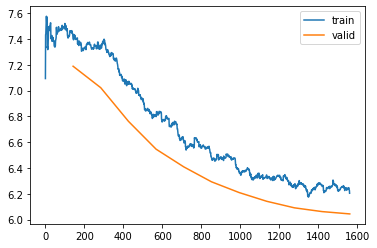

In [ ]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [ ]:
for m in learn.metrics:
  print(f'{m.name}: {m.value *100}')

rouge1: 24.19504176075978
rouge2: 7.090458568924118
rougeL: 20.437927788055752


In [ ]:
learn.show_results(learner=learn, max_n= 10)

,text,target,prediction
0,the app permits the purchase of virtual currency virtual money and use of that virtual money to purchase virtual items or services that we expressly make available for use in the app virtual goods. the purchase of virtual money and virtual goods is limited to account holders who are either a 18 years of age or older or b under the age of 18 and have the consent of a parent to make the purchase. parents of children under the age of 18 can consult the ios or google play settings for their app to restrict in app purchases but should also monitor their children s accounts for unexpected activity including the purchase of virtual money or virtual goods. purchases of virtual money and virtual goodsvirtual money is a category of content so the purchase of virtual money grants you only a limited nontransferable non sublicensable revocable license to use such virtual money to access and purchase virtual goods in conjunction with your personal noncommercial use of the services. you acknowledge that you do not acquire any ownership rights in or to the virtual money virtual goods or other content any balance of virtual goods or virtual money does not reflect any stored value. you agree that virtual money and virtual goods have no monetary value and do not constitute actual currency or property of any type. virtual money may be redeem,you agree that all sales by us to you of virtual money and virtual goods are final and that we will not permit exchanges or refunds for any unused virtual money or virtual goods once the transaction has been made. purchases by end users outside the u s virtual money and virtual goods may only be purchased and held by legal residents of countries where access to and use of the services are permitted. if you live in the european union you have certain rights to withdraw from online purchases,app allows users to purchase virtual goods and virtual currency . [X_SEP] parents of children under the age of
1,your content and conductas a youtube account holder you may submit content to the service including videos and user comments. you understand that youtube does not guarantee any confidentiality with respect to any content you submit. you shall be solely responsible for your own content and the consequences of submitting and publishing your content on the service. you affirm represent and warrant that you own or have the necessary licenses rights consents and permissions to publish content you submit and you license to youtube all patent trademark trade secret copyright or other proprietary rights in and to such content for publication on the service pursuant to these terms of service. for clarity you retain all of your ownership rights in your content. however by submitting content to youtube you hereby grant youtube a worldwide non exclusive royalty free sublicenseable and transferable license to use reproduce distribute prepare derivative works of display and perform the content in connection with the service and youtube s and its successors and affiliates business including without limitation for promoting and redistributing part or all of the service and derivative works thereof in any media formats and through any media channels. you also hereby grant each user of the service a non exclusive license to access your content through the service and to use reproduce distribute display and perform such content as permitted through the functionality of the,you are responsible for your uploaded content. don t violate copyright laws. our community guidelines define what we don t want you to submit.,you retain all of your ownership rights in your content . [X_SEP] you grant youtube a worldwide royalty free


# Evaluation Test

In [ ]:
learn.validate(dl=test_dl, cbs=[HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)])

(#7) [6.126960754394531,0.24195041760759778,0.07090458568924118,0.20437927788055754,0.2610626167299408,0.08937610576505811,0.22582004277681933]

In [ ]:
for m in learn.metrics:
  print(f'{m.name}: {m.value *100}')

rouge1: 24.19504176075978
rouge2: 7.090458568924118
rougeL: 20.437927788055752
rouge1: 26.10626167299408
rouge2: 8.937610576505811
rougeL: 22.582004277681932
